
# GPT-2 Decoder Model for Sentiment Classification (extra task)

This notebook implements a sentiment classification pipeline using a decoder-based transformer model (GPT-2).
We classify financial tweets into three sentiment categories: **bearish (0), neutral (1), bullish (2)**.
The notebook includes steps for data loading, preprocessing, tokenization, model configuration, training, and evaluation.

---


In [ ]:
# !pip install transformers datasets scikit-learn pandas torch
# !pip install accelerate

In [ ]:
# !pip uninstall -y transformers
# !pip install transformers


---

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments,TrainerCallback, EarlyStoppingCallback

---

## Set the seed for reproducibility

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


---

## Load the dataset

In [27]:
# Load train and test data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [28]:
print(train_df.head())
print(test_df.head())

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0
   id                                               text
0   0  ETF assets to surge tenfold in 10 years to $50...
1   1  Here’s What Hedge Funds Think Evolution Petrol...
2   2  $PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3   3  China is in the process of waiving retaliatory...
4   4  Highlight: “When growth is scarce, investors s...


---

## Simply Preprocessing

We perform basic data preprocessing that was applied in the preprocessing file as well, the only difference is that we do not remove non-alphanumeric characters becuase we want to preserve emojis, punctuation, and special characters. We only apply small preprocessing because GPT2 was trained on raw data and it can benefit for example from emojis

In [29]:
def clean_text_gpt2(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [30]:
# Applying the preprocessing
train_df['text'] = train_df['text'].apply(clean_text_gpt2)
test_df['text'] = test_df['text'].apply(clean_text_gpt2)

---
## Loading and Tokenizing the splitted data
<br> GPT-2 does not have a dedicated padding token (since it was pretrained for language modeling where padding wasn't needed).
<br> Thus, we manually assign the special EOS (end-of-sequence) token to serve as padding token.This allows padding during fine-tunning stage.

In [31]:
# Prepare GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [32]:
# Spliting train into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_df['label'].tolist()
)

In [33]:
# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=128)

---
## Custom Dataset Class for GPT-2 Fine-Tuning

We define a custom PyTorch Dataset class (`TweetDataset`) to handle our tokenized data and labels. We build it, because the Hugging Face Trainer requires datasets that return both inputs and labels in dictionary format.


In [34]:
# Dataset class
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [35]:
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings)

---

## Custom Callback for Logging Training and Evaluation Metrics

We implement a custom callback class (`LossAndMetricsLogger`) that extends Hugging Face's `TrainerCallback`. This allows us to capture and store losses and evaluation metrics during training for further analysis and visualization.

In [36]:
class LossAndMetricsLogger(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.eval_f1s = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                self.eval_accuracies.append(logs['eval_accuracy'])
            if 'eval_f1' in logs:
                self.eval_f1s.append(logs['eval_f1'])

logger = LossAndMetricsLogger()

---
## Load GPT-2 Model with Classification Head

We load the pretrained GPT-2 model and adapt it for our sentiment classification task Since GPT-2 was originally trained for language modeling, we use `GPT2ForSequenceClassification` to add a new classification head on top of the pretrained transformer layers.

- `num_labels=3` specifies the number of output classes.
- Since GPT-2 has no native padding token, we assign its end-of-sequence token (eos_token) as the padding token
- Dropout probabilities (`hidden_dropout_prob`, `attn_pdrop`, and `embd_pdrop`) are increased to 0.3 to reduce overfitting during fine-tuning (because we train on relative small dataset)


In [37]:
# Load GPT2 decoder model for classification (we have three labels 0,1,2)
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)
model.config.pad_token_id = model.config.eos_token_id

model.config.hidden_dropout_prob = 0.3
model.config.attn_pdrop = 0.3
model.config.embd_pdrop = 0.3

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---
## Define Evaluation Metrics

We create a funcion that computer accuracy, macro f1 score, maacro precision and macro recall. Those metrics are later used to evaluate the results of the model.

In [38]:
# Evaluation Metrics - we are using macro scores because our labels are inbalanced
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

---

## Train the model
<br> Model is trained to select the best model based on the macroF1  score.

In [20]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    learning_rate=5e-5,
    weight_decay=0.05,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1", # we are considering macro f1 score for evaluation of the best model
    save_total_limit=1,
    seed=42,
    report_to="none"

)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger, EarlyStoppingCallback(early_stopping_patience=2)]
)

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.347700,0.480566,0.836040,0.778741,0.803213,0.761445
2,0.339600,0.471982,0.855422,0.809872,0.819728,0.801838
3,0.358400,0.859906,0.861184,0.810438,0.838415,0.788139
4,0.250100,0.888943,0.849660,0.811254,0.799590,0.825211
5,0.174700,1.145403,0.860136,0.818516,0.820495,0.816693
6,0.062400,1.439283,0.854374,0.810353,0.822937,0.800320
7,0.000300,1.526135,0.850183,0.809497,0.801809,0.819824


TrainOutput(global_step=6685, training_loss=0.23433281272802325, metrics={'train_runtime': 1416.9785, 'train_samples_per_second': 53.875, 'train_steps_per_second': 6.74, 'total_flos': 2781751537281024.0, 'train_loss': 0.23433281272802325, 'epoch': 7.0})

## Plot the train and validation loss

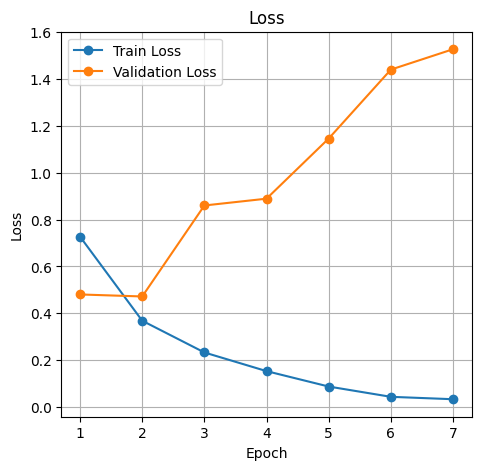

In [22]:
# Calculate train losses per epoch
train_steps_per_epoch = len(logger.train_losses) // len(logger.eval_losses)
train_losses_epoch = [
    np.mean(logger.train_losses[i*train_steps_per_epoch : (i+1)*train_steps_per_epoch])
    for i in range(len(logger.eval_losses))
]
epochs = range(1, len(logger.eval_losses) + 1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses_epoch, label="Train Loss", marker='o')
plt.plot(epochs, logger.eval_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)


We got the best macroF1 score for the 6th epoch, but in that epoch difference between training and validation loss is quite significant which means that model fits the training data much better than it generalizes to new (validation) data. It most likely due too many epochs.

<br> Model seems to be the best at epoch 2, where we can see a good trade-off between loss and other metrics.

---

## Running the  model with less epoch (only 2)

In [39]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results_epoch2",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    learning_rate=5e-5,
    weight_decay=0.05,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    seed=42,
    report_to="none"
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger, EarlyStoppingCallback(early_stopping_patience=2)]
)

In [40]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.315000,0.426438,0.859089,0.816783,0.819403,0.819601
2,0.180600,0.426372,0.867470,0.827156,0.832606,0.823080


TrainOutput(global_step=1910, training_loss=0.45564663666081057, metrics={'train_runtime': 421.3767, 'train_samples_per_second': 36.234, 'train_steps_per_second': 4.533, 'total_flos': 794786153508864.0, 'train_loss': 0.45564663666081057, 'epoch': 2.0})

---

## Evaluation of the best model


Classification Report on Validation Set:

              precision    recall  f1-score   support

 Bearish (0)     0.7559    0.7847    0.7700       288
 Bullish (1)     0.8405    0.7662    0.8016       385
 Neutral (2)     0.9015    0.9183    0.9098      1236

    accuracy                         0.8675      1909
   macro avg     0.8326    0.8231    0.8272      1909
weighted avg     0.8672    0.8675    0.8669      1909



<Figure size 600x600 with 0 Axes>

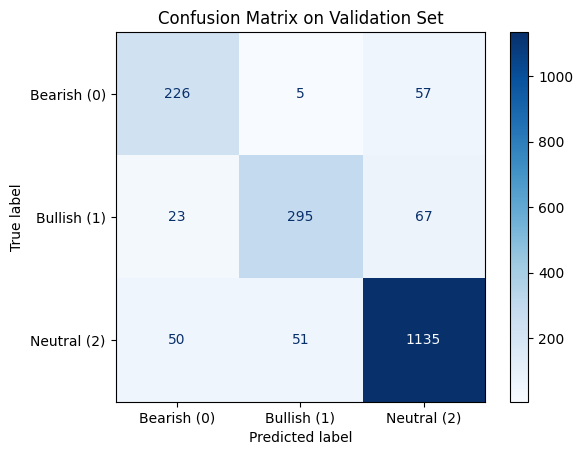

In [41]:
# Predict on validation set
predictions_val = trainer.predict(val_dataset)

# Extract true labels and predicted labels
y_true = predictions_val.label_ids
y_pred = predictions_val.predictions.argmax(axis=1)

# Classification report
target_names = ["Bearish (0)", "Bullish (1)", "Neutral (2)"]
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)

print("\nClassification Report on Validation Set:\n")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Validation Set")
plt.show()


---

## Predictions on the test dataset

In [ ]:
# Predict on test set
predictions = trainer.predict(test_dataset)
preds_test = np.argmax(predictions.predictions, axis=1)

In [ ]:
# File with test label 
test_df['label'] = preds_test
test_df[['id','label']].to_csv("pred_decoder.csv", index=False)

print("Prediction file saved as pred_decoder.csv")